In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import timeit
import itertools as it
%matplotlib inline

In [2]:
def algoB(B) :

    allval, allvect = scipy.linalg.eigh(B)
    valpos          = allval[allval>0]
    vectpos         = allvect[:, allval>0]
    S               = np.fliplr(np.array(vectpos>0, dtype=int)) ###fliplr permet d'organiser les vecteur propres du "grand" au plus "petit"
    pos_one         = (S[:,0]==1) #vecteur de positions des uns

    for i in range(1, len(valpos)):
        S[pos_one,i] = np.zeros(np.sum(pos_one>0)) #met des 0 aux positions où dans la colonne d'avant il y avait des uns.
        pos_one      = pos_one + (S[:,i]==1) #actualise le vecteur de positions des uns avec les uns de la colonne en cours
        if (np.sum(pos_one) >= n) :
            maxgroup = i+1
            break
    S_opt = S[:, :(maxgroup)]
    Q = np.trace(np.dot(np.dot(S_opt.transpose(),B),S_opt))/(2*m)
    return(dict(S_opt=S_opt, Q=Q, nb_group= maxgroup))

In [3]:
def algoC(c=2, p=2):
    allval, allvect = scipy.linalg.eigh(B)
    val_p, vect_p = scipy.linalg.eigh(B, eigvals=(len(B)-p, len(B)-1))
    alpha         = (1/(n-p))*np.sum(allval[:(len(allval)-p)])
    Z             = np.tile(np.sqrt(val_p-alpha),n).reshape(p, n)
    r_mat         = Z*vect_p.transpose()

    #On test tous le monde à chaque fois
    count = 0
    x     = np.zeros(n,dtype=int)
    #vecteur permettant d'ajouter ou de retirer des sommets
    add   = np.zeros(n, dtype=int)  
    drop  = np.zeros(n, dtype=int)
    
    #Initialisation de R_1, on met l'individu 1 par défaut
    x[0]  =1
    R     = r_mat[:,0]
    while count < n:
        count=0
        for i in range(0,n):
            if np.dot(R, r_mat[:, i])>0:
                if x[i]!=1 :
                    add[i] = 1
                    x[i]   = 1
                else:
                    count = count+1
            else:

                if x[i]==1 :
                    drop[i] = 1
                    x[i] = 0
                else:
                    count = count+1
    R= R+ r_mat[:,add].sum(axis=1) - r_mat[:,drop].sum(axis=1)    
    S      = np.zeros(n*2, dtype=int).reshape(n,2)
    S[:,0] = x
    S[:,1] = 1-x
    Q= np.trace(np.dot(np.dot(S.transpose(),B),S))/(2*m)
    return(dict(S=S, Q=Q))

In [584]:
def subdivision2(x, B, xold, c=2, p=2):
    #initialisation des valeurs
    ng                = np.sum(x)

    #Calculs des termes diagonaux
    B_crop            = B[x==1,:][:,x==1]
    Bsum              = B_crop.sum(axis=1)
    B_g               = B_crop - np.diag(np.fromiter(iter(Bsum),dtype=float)) 
    
    #Diagonalisation de la matrice B_{ij}^G
    val_p_g, vect_p_g = scipy.linalg.eigh(B_g, eigvals=(len(B_g)-p,len(B_g)-1))
    
    #Calcul du alpha optimal
    allval, allvect   = scipy.linalg.eigh(B_g)
    alpha_g           = (1/(ng-p))*np.sum(allval[:(len(allval)-p)])
    
    #Calcul de la matrice des r_i
    Z_g               = np.tile(np.sqrt(val_p_g-alpha_g),ng).reshape(p,ng)
    r_mat_g           = Z_g*vect_p_g.transpose()
    
    #Algorithme
    count   = 0
    xg      = np.zeros(ng,dtype=int)
    xg[0]   = 1
    R_g     = r_mat_g[:,0]
    #vecteur permettant d'ajouter ou de retirer des sommets
    add   = np.zeros(n, dtype=int)  
    drop  = np.zeros(n, dtype=int)
    while count < ng:
        count = 0
        for i in range(0,ng):
            
            if np.dot(R_g, r_mat_g[:, i])>0:
                if (xg[i] != 1) :
                    add[i] = 1
                    xg[i]  = 1
                else:
                    count = count+1
            else:
            
                if (xg[i] ==1 ) :
                    drop[i] = 1
                    xg[i]   = 0
                else:
                    count = count+1
    R_g= R_g+ r_mat_g[:,add].sum(axis=1) - r_mat_g[:,drop].sum(axis=1) 
    
    #Stockages des valeurs dans une matrice S
    Sg       = np.zeros(ng*c, dtype=int).reshape(ng,c)
    Sg[:,0]  = xg
    Sg[:,1]  = 1-xg
    
    S = np.zeros(n*2,dtype=int).reshape(n,2)
    S[xold ==1,0]  = xg
    S[xold ==1,1]  = 1-xg

    
    #Calcul de la différence de modularité
    Delta_Q  = np.trace(np.dot(np.dot(Sg.transpose(), B_g), Sg))/(2*m)
    
    return(dict(Sg1=Sg[:,0], Sg2=Sg[:,1], Bg= B_g, dQ= Delta_Q, S1=S[:,0], S2=S[:,1]))

In [4]:
#G  = nx.read_edgelist("facebook.txt", create_using = nx.Graph(), nodetype = int)
#G   = nx.read_gml('karate.gml')
G   = nx.read_gml('lesmis.gml')
m   = G.number_of_edges()
n   = len(G)
A   = nx.adjacency_matrix(G)
deg = G.degree()
k   = np.fromiter(iter(deg.values()), dtype=int)
P   = np.outer(k,k)/(2*m)
B   = A-P

### ALGO A

In [302]:
# Leading eigenvector algorithm
val, vect = scipy.linalg.eigh(B, eigvals=(len(B)-1,len(B)-1))
valuesA         = np.array(vect.flatten()>0,dtype=int) -1*np.array(vect.flatten()<=0,dtype=int)

In [303]:
(1/(4*m))*np.dot(np.dot(valuesA,B),valuesA)

matrix([[ 0.36108097]])

### ALGO B 

In [304]:
val_algoB= algoB(B)

In [305]:
val_algoB["Q"]

0.51364777729555466

In [249]:
valuesB = np.zeros(n)
for i in range(val_algoB['S_opt'].shape[1]):
    valuesB = valuesB + (i+1)*val_algoB['S_opt'][:,i]

### ALGO C

In [463]:
output_algoC = algoC()

In [585]:
x0 = np.ones(n,dtype=int)
x1 = subdivision2(x0,B,xold=x0)

In [586]:
x1["dQ"]

0.36108097216194424

In [590]:
sub11 = subdivision2(x1["Sg1"],x1["Bg"],xold=x1["S1"])
sub12 = subdivision2(x1["Sg2"],x1["Bg"],xold=x1["S2"])

In [591]:
print(sub11["dQ"], sub12["dQ"])

0.119334738669 -0.0144305288611


In [592]:
sub111 = subdivision2(sub11["Sg1"],sub11["Bg"],xold=sub11["S1"])
sub112 = subdivision2(sub11["Sg2"],sub11["Bg"],xold=sub11["S2"])

In [593]:
print(sub111["dQ"],sub112["dQ"])

0.00826151652303 0.0461590923182


In [5]:
Sopt = np.zeros(n*100).reshape(n,100)

In [6]:
Sopt[:,0]= x1["S2"]
Sopt[:,1]= sub111["S1"]
Sopt[:,2]= sub111["S2"]
Sopt[:,3]= sub112["S1"]
Sopt[:,4]= sub112["S2"]

NameError: name 'x1' is not defined

In [595]:
np.trace(np.dot(np.dot(Sopt.transpose(),B),Sopt))/(2*m)

0.53483631967263934

In [438]:
valuesC = np.zeros(n)
for i in range(Sopt.shape[1]):
    valuesC = valuesC + (i+1)*Sopt[:,i]

### Représentation du graphe

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


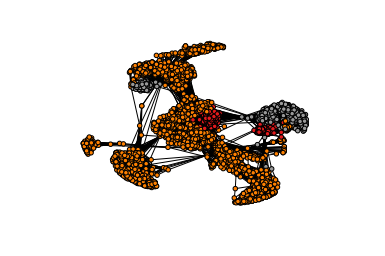

In [439]:
print(nx.info(G))

#Create network layout for visualizations
spring_pos = nx.spring_layout(G)

#plt.axis("off")
#nx.draw_networkx(G, pos = spring_pos, with_labels = False, node_size = 20)

###
plt.axis("off")
nx.draw_networkx(G, pos = spring_pos,  node_color = valuesC, 
                 font_size=20,node_size = 20, with_labels = False, cmap=plt.cm.Set1)

